# House Sales in King County, USA
### Predict house price using regression

W tym zadaniu będziemy szacować ceny domów.

In [3]:
import numpy as np 
import pandas as pd 
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv('kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Dataframe zawiera dane typu :
 - 

Dane zawierają takie dane jak:
- id - unikalne id domu
- date - data sprzedaży domu
- price - cena sprzedanego domu


- bedrooms
- bathrooms - liczba łazienek, gdzie 0.5 znaczy łazienka bez prysznica
- sqft_living
- sqft_lot
- sqft_above - powierzchnia domu nad powierzchnią ziemi 
- sqft_basement
- yr_built
- yr_renovated
- floors - liczba pięter


- waterfront - Zmienna określająca czy mieszkanie wychodziło na nabrzeże
- view - ocena widoku [0, 4]
- condition - stan mieszkania [1, 5]
- grade - ocena zgodności budynku z projektem i jakości wykonania [1, 13]


- zipcode
- lat - Szerokość geograficzna
- long - Długość geograficzna
- sqft_living15 - powierzchnia mieszkań najbliższych 15 sąsiadów
- sqft_lot15 - powierzchnia ziemi najbliższych sąsiadów

Możemy wyszczególnić w tych danych 4 kategorie:
 - dane ogólne
 - specyfikacja domu
 - dane które są wyznaczane przez ludzi
 - dane o okolicy domu

Wynika stąd, że dane typu "id" powinny zostać usunięte z tego względu, że mogą powodować szum, z drugiej strony w id może być ukryta jakaś informacja, z której model mógłby wywnioskować cenę. Aby przygotować dane należy też udostępnić datę sprzedaży w bardziej przystępny format.

In [5]:
df[['year', 'month', 'day']] = pd.DataFrame([ [int(x[0:4]), int(x[4:6]), int(x[6:8])] for x in df['date'].tolist() ])
df = df.drop(['date', 'id'], axis=1)
Y = df['price']
X = df.drop(['price'], axis=1)

In [8]:
df.groupby(['condition']).count()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
condition,,,,,,,,,,,,,,,,,,,,,
1,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
2,172,172,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172
3,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,...,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031
4,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,...,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679
5,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,...,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701


In [24]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  
                      test_size = 0.3, random_state = 123) 

### Przeszukiwanie przestrzeni hiperparametrów

In [28]:
xgb1 = XGBRegressor()
parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, .04, .05, .06, .07], #so called `eta` value
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [3, 4, 5, 6],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 700, 100]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 12,
                        verbose=True)

xgb_grid.fit(X, Y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 300 candidates, totalling 600 fits
0.877865911661787
{'colsample_bytree': 0.7, 'learning_rate': 0.06, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 700, 'nthread': 1, 'objective': 'reg:squarederror', 'subsample': 0.7}


### Wyznaczone hiperparametry z modelu

In [31]:
xgb2 = XGBRegressor(colsample_bytree=0.7, learning_rate=0.06, max_depth=5, min_child_weight=6, n_estimators=700, nthread=1, objective='reg:squarederror', subsample=0.7)

In [36]:
xgb2.fit(train_X, train_Y)
score = xgb2.score(train_X, train_Y)  
print("Training score: ", score)
score = xgb2.score(test_X, test_Y)  
print("Test score: ", score)
pred = xgb2.predict(test_X)
rmse = np.sqrt(MSE(test_Y, pred)) 
print("RMSE : % f" %(rmse)) 

Training score:  0.9711698297228819
Test score:  0.905722369519171
RMSE :  113149.749407


In [37]:
print (test_Y[:10], pred[:10])

5506     532500.0
9279     410000.0
16034    782500.0
6608     995000.0
20359    279000.0
8798     175000.0
10035    689000.0
13321    275000.0
15842    465000.0
12119    506000.0
Name: price, dtype: float64 [617686.7  525400.25 869056.5  986680.4  302756.4  301077.2  696768.8
 419573.34 457880.12 462333.66]


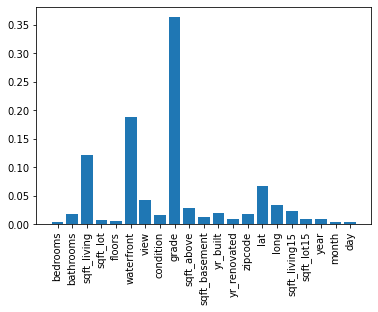

In [45]:
import matplotlib.pyplot as pyplot
pyplot.bar(X.columns, xgb2.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.show()

Wynika stąd, że rzeczą najbardziej wpływającą na cenę domu jest zgodność domu z założeniami konstrukcyjnymi i jakość wykonania, które są ustalane na podstawie czynnika ludzkiego.


Dwoma kolejnymi ważnymi atrybutami domu jest czy dom miał widok na nabrzeże oraz jaka była powierzchnia salonu.


Co ciekawe na powyższym wykresie można zauważyć podwyższony słupek przy szerokości geograficznej. Symbolizuje to lokalizacje, w których ceny są odpowiednio wyższe lub też niższe. Kolejnym atrybutem który pomaga określić cenę jest metraż domów w sąsiedzctwie. Co może wynikać z faktu, że domu w jednej okolicy często bywają do siebie podobne.


Co ciekawe mały wpływ na cenę domu ma fakt czy dom który jest sprzedawany jest zadbany czy też nie, natomiast widać, że stosunkowo mało domów dostało 1 i 2 w tej kategorii. Jest to oceniane przez człowieka i dlatego ta informacja może być zaburzona.